In [1]:
import pystan
import pandas as pd
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

In [2]:
figs_path = os.path.join(os.getcwd(),"figs")
data_path = os.path.join(os.getcwd(),"cerebellum_data")
pickle_path = os.path.join(os.getcwd(),"pickled_data")

In [3]:
#unpickle data

#theta
with open(os.path.join(pickle_path, "2l-theta.pickle"), 'rb') as handle:
    theta = pickle.load(handle)
thetas = pd.DataFrame(theta)
    
#stan model
with open(os.path.join(pickle_path, '2l-constant_sm.pickle'), 'rb') as handle:
    constant_sm = pickle.load(handle)

#true lambdas
with open(os.path.join(pickle_path, '2l-lam.pickle'), 'rb') as handle:
    lam = pickle.load(handle)

#simulated data (gene counts)
with open(os.path.join(pickle_path, '2l-fake_data.pickle'), 'rb') as handle:
    fake_data = pickle.load(handle)

#stan output
with open(os.path.join(pickle_path, '2l-parameter_samples.pickle'), 'rb') as handle:
    parameter_samples = pickle.load(handle)
ps = parameter_samples.to_dataframe()

In [4]:
###### same preprocessing as before ######

def process_data():
    cached = {}
    output = []
    for s in ["counts", "genes", "metadata"]:
        #check if we have already processed the dataset
        filename = os.path.join(data_path,"cerebellum_%s.pickle" % s)
        cached = os.path.isfile(filename)
        if cached:
            output.append(pd.read_pickle(filename))
        else:
            #if not processed, read from csv and save pickled file
            csv_file = os.path.join(data_path, "cerebellum_%s.csv" % s)
            df = pd.read_csv(csv_file,index_col=0)
            if s in ['counts','genes']:
                df = df.transpose()
            df.to_pickle(filename)
            output.append(df)
    return output

counts, genes, metadata = process_data()

considered_types = ['Granule', 'Purkinje', 'Astrocytes']
#filter by cell type
considered_cells = counts.loc[metadata['liger_ident_coarse'].isin(considered_types)]
#filter genes
newcounts = considered_cells.filter(genes.loc['gene'].tolist())
#normalize matrix of counts
#(note: these proportions are conditioned on genes being in frequent set)
c_subset = newcounts.div(newcounts.sum(axis=1), axis=0)

In [5]:
#partition the filtered gene frequency matrix into astrocytes, granule, purkinje
astrocytes = newcounts[0:1000]
granule = newcounts[1000:2000]
purkinje = newcounts[2000:3000]

In [6]:
rng = np.random.default_rng()

In [7]:
def downsample_data(df, size=1000, threshold=1000):
    c_df = df[df.sum(axis=1) > threshold]
    fracs = c_df.div(c_df.sum(axis=1),axis=0).to_numpy()

    down = []

    for row in fracs:
        down.append(rng.multinomial(size,fracs[0]))

    return pd.DataFrame(down, index=c_df.index.values)

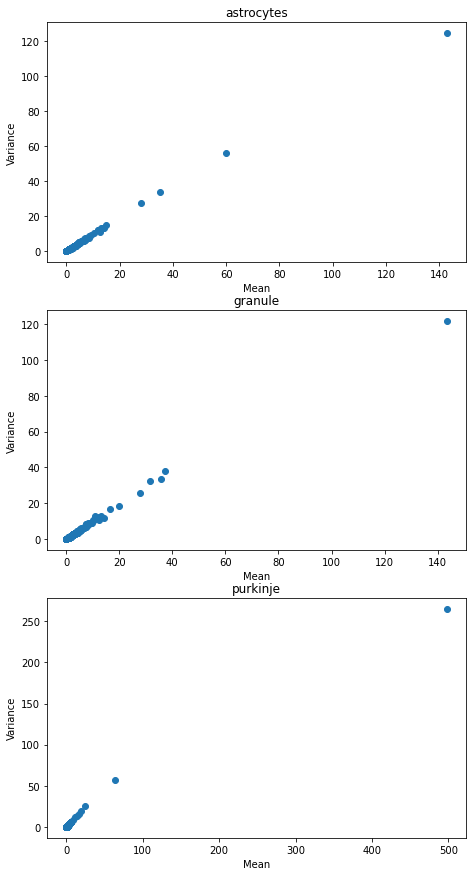

In [8]:
#plot mean vs variance for filtered gene count data

fig, ax = plt.subplots(3,figsize=(7.5,15))

for j, (cell, celltype) in enumerate(zip([astrocytes,granule,purkinje],["astrocytes","granule","purkinje"])):

    mean_std = []
    downsampled = downsample_data(cell)

    for i in range(len(downsampled.columns)):
        mean_std.append((downsampled[i].mean(), downsampled[i].std()**2))

    ax[j].scatter(*zip(*mean_std))
    ax[j].set_title(celltype)
    ax[j].set_xlabel("Mean")
    ax[j].set_ylabel("Variance")

plt.show()

In [9]:
#compute the distributions of gene expression for each type of cell
c_transp = c_subset.transpose()
c_transp["Astrocytes"], c_transp["Granule"], c_transp["Purkinje"] \
    = c_transp.iloc[:,0:1000].mean(axis=1),\
    c_transp.iloc[:,1000:2000].mean(axis=1),\
    c_transp.iloc[:,2000:3000].mean(axis=1)

#beta is the 3 x 899 matrix of average gene expressions for each cell type
beta = c_transp[["Astrocytes","Granule","Purkinje"]].transpose().to_numpy()

In [10]:
#retrieve the ground truth thetas for contributions of a cell to 

thetas["Astrocytes"] = thetas.loc[:,range(0,1000)].sum(axis=1)
thetas["Granule"] = thetas.loc[:,range(1000,2000)].sum(axis=1)
thetas["Purkinje"] = thetas.loc[:,range(2000,3000)].sum(axis=1)

In [11]:
t = thetas[["Astrocytes", "Granule", "Purkinje"]]

In [12]:
#retrieve predicted thetas, betas from stan model output
pred_theta = ps.transpose()[ps.transpose().index.str.match(r"(theta)")]
pred_beta = ps.transpose()[ps.transpose().index.str.match(r"(beta)")]

#rearrange pandas data into numpy arrays
m_theta = np.array([pred_theta.loc[:,:249].mean(axis=1)[2500:3750].to_numpy(),
            pred_theta.loc[:,:249].mean(axis=1)[0:1250].to_numpy(),
            pred_theta.loc[:,:249].mean(axis=1)[1250:2500].to_numpy()])
m_beta = np.array([
            pred_beta.loc[:,:249].mean(axis=1)[2::3].to_numpy(),
            pred_beta.loc[:,:249].mean(axis=1)[0::3].to_numpy(),
            pred_beta.loc[:,:249].mean(axis=1)[1::3].to_numpy()])

#retrive stan predicted lambdas via matrix product theta * beta
lambdas = 5000 * m_theta.transpose().dot(m_beta)

In [13]:
#round lambdas to integers for binning
t_lambdas = np.ceil(lambdas-1/2)

/broad/thechenlab/mdiao/lda-env/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/broad/thechenlab/mdiao/lda-env/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


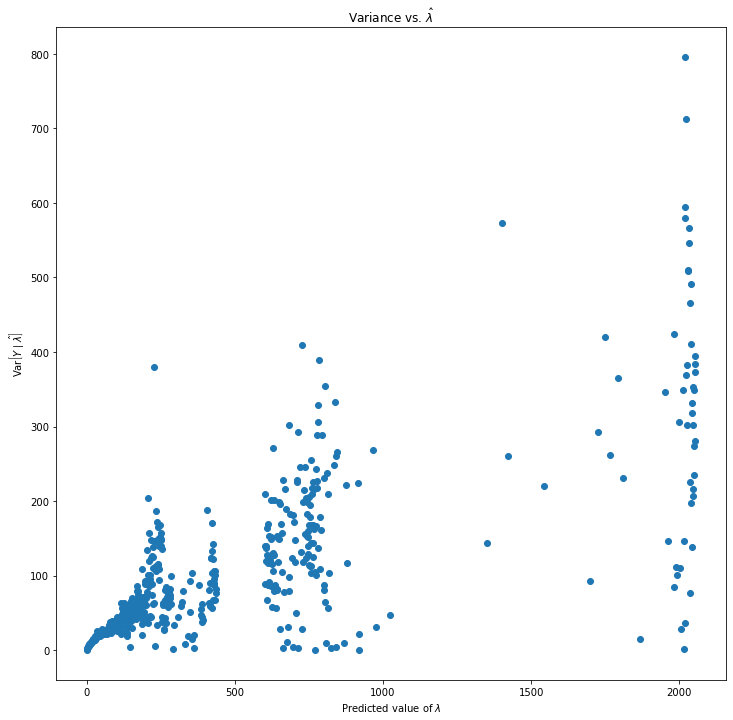

In [14]:
#generate mean vs variance plots for Y vs predicted lambdas
plt.rcParams["figure.figsize"] = (12,12)  

points = []

for x in np.unique(t_lambdas):
    points.append((x, fake_data[t_lambdas == x].std(ddof=1)))

plt.xlabel(r"Predicted value of $\lambda$")
plt.ylabel(r"Var$\left[Y\mid \hat{\lambda}\right]$")
plt.title(r"Variance vs. $\hat\lambda$")
plt.scatter(*zip(*points))
plt.show()

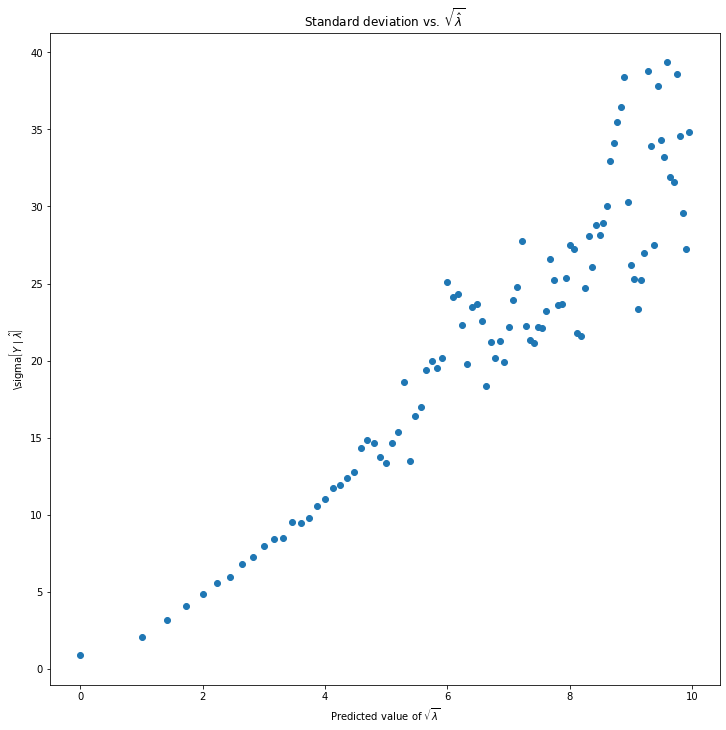

In [15]:
#some more plots

threshold=100

points = []

for x in np.unique(t_lambdas[t_lambdas < threshold]):
    lams = fake_data[t_lambdas == x]
    std = fake_data[t_lambdas == x].std(ddof=1)
    #if std > 1/6 * x:
    #    print(x, std)
    #    print(sorted(np.unique(lams[abs((lams-x)/std) > 2])))
    #    sortedlams = sorted(lams)
    #    print(sortedlams[0], sortedlams[-1])
    #    print("------------------------")
    points.append((x ** 0.5, std))

plt.xlabel(r"Predicted value of $\sqrt{\lambda}$")
plt.ylabel(r"\sigma$\left[Y\mid \hat{\lambda}\right]$")
plt.title(r"Standard deviation vs. $\sqrt{\hat\lambda}$")
plt.scatter(*zip(*points))
plt.show()

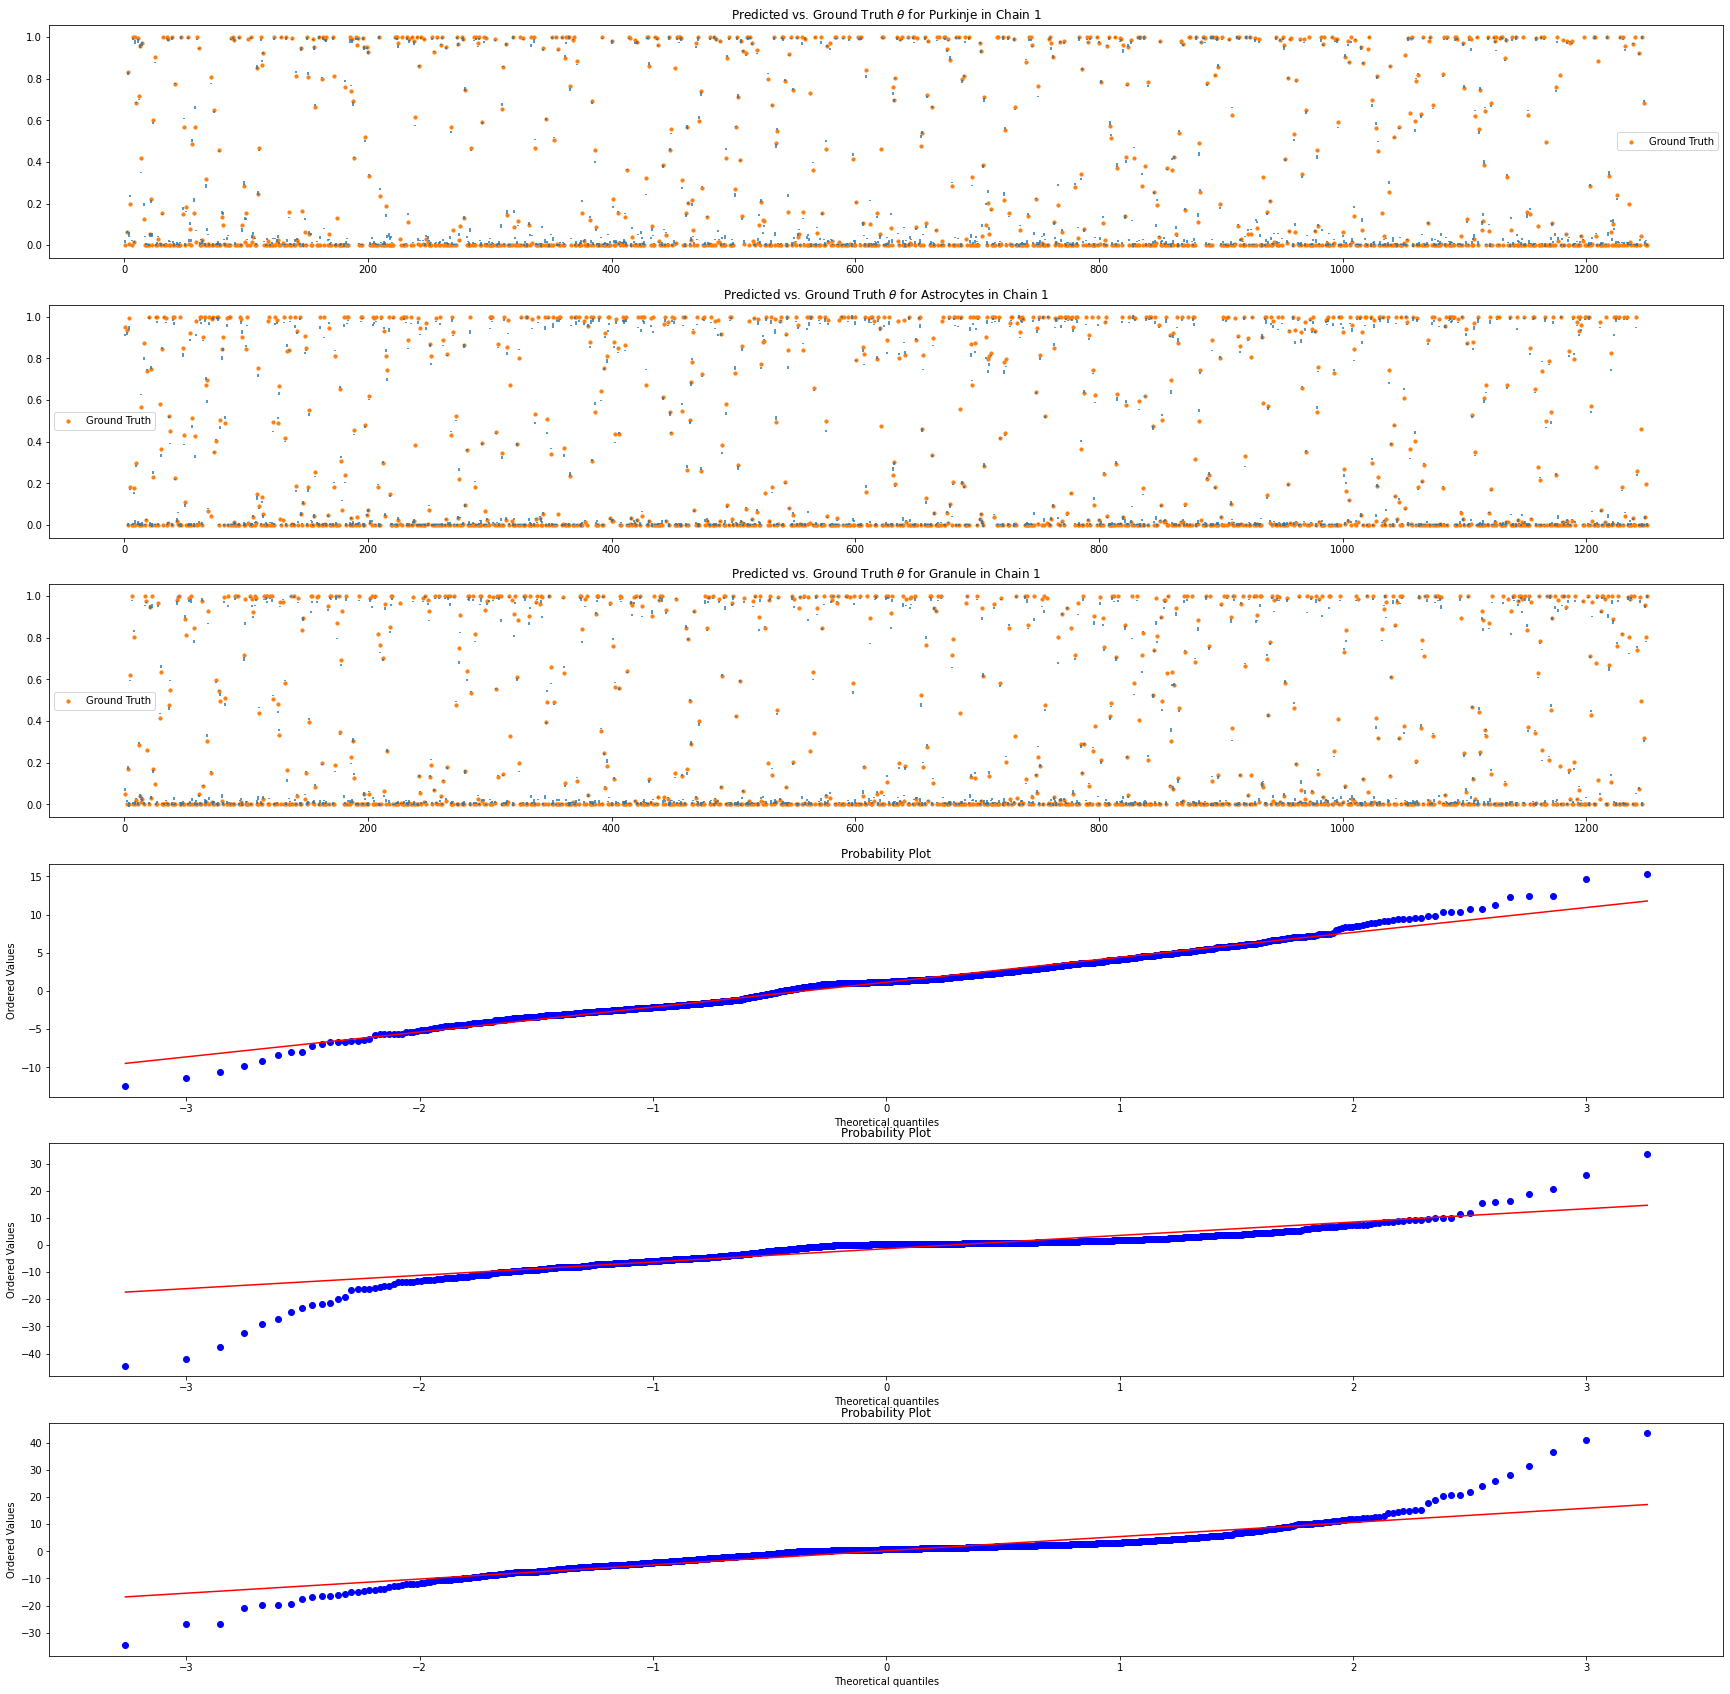

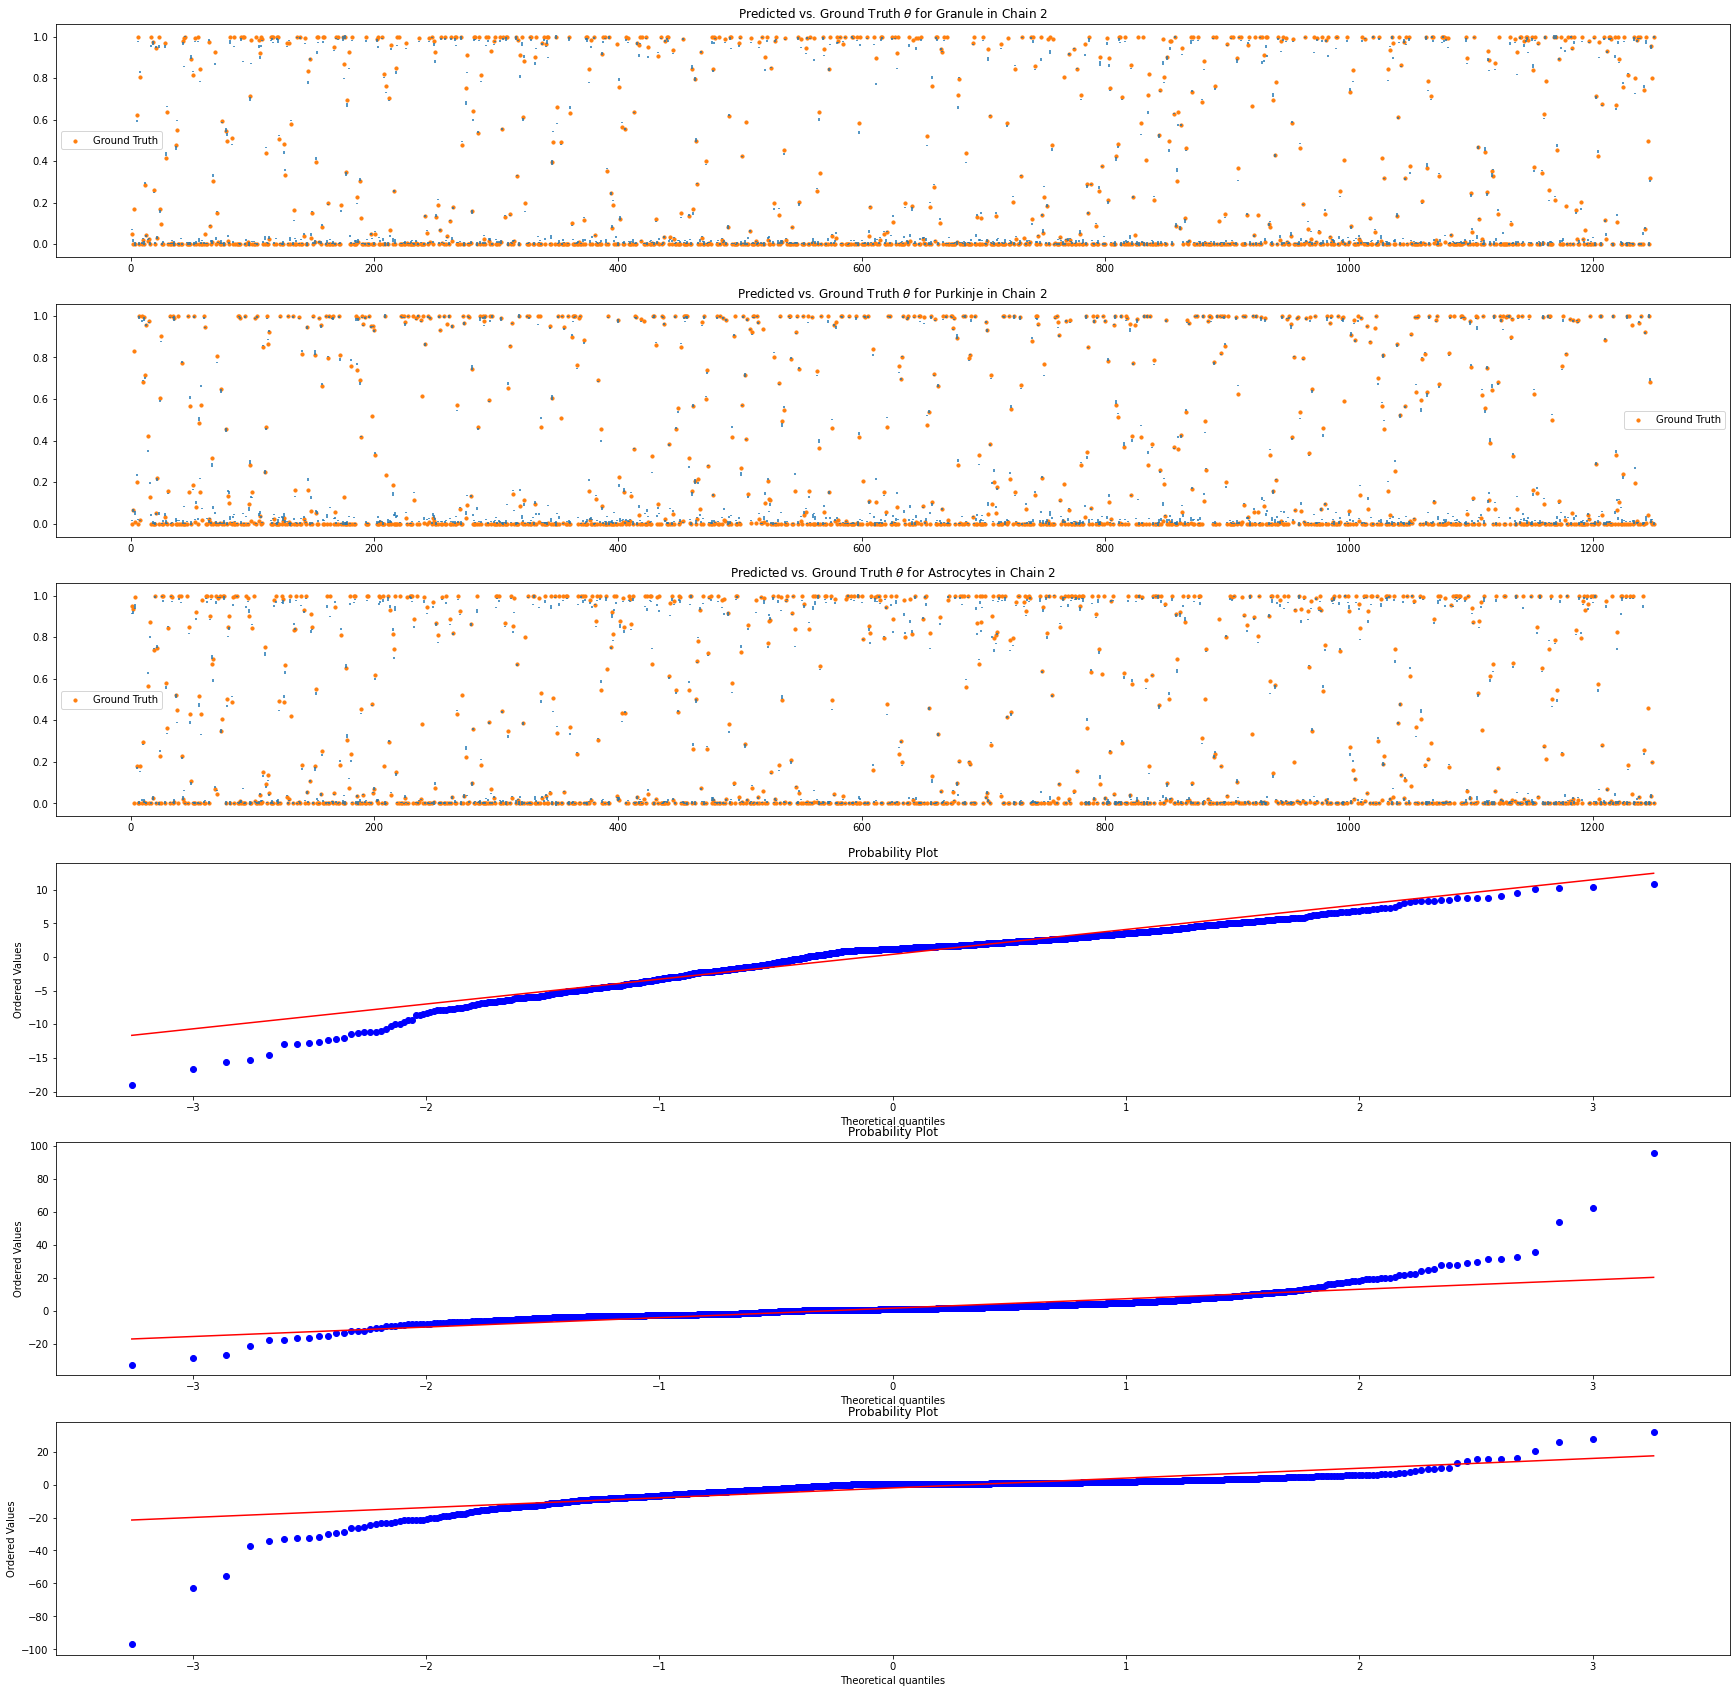

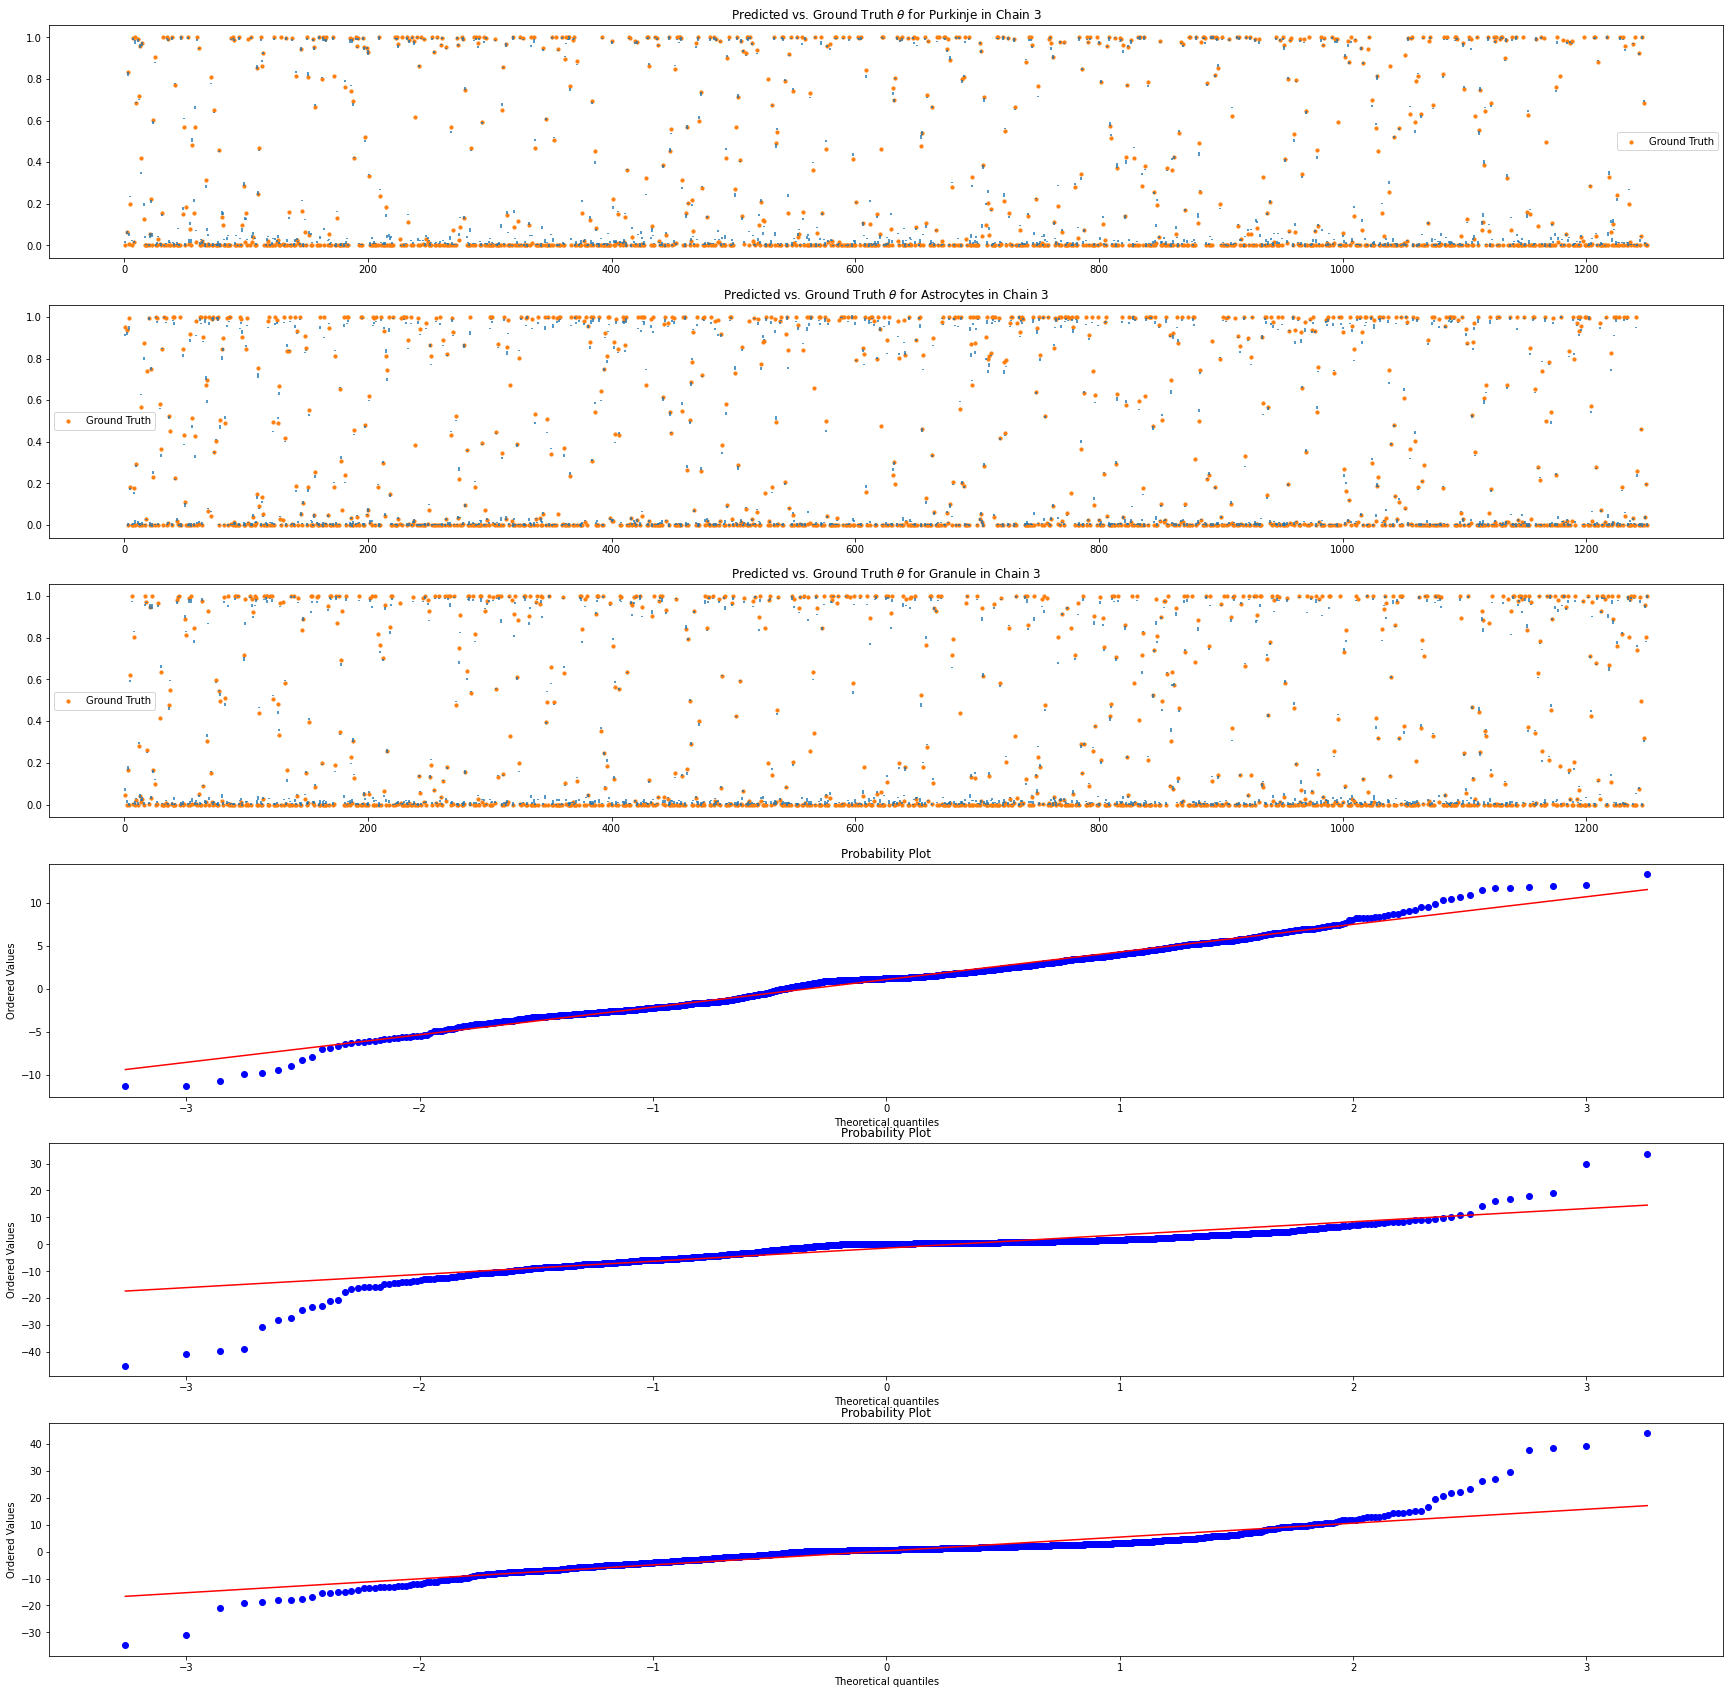

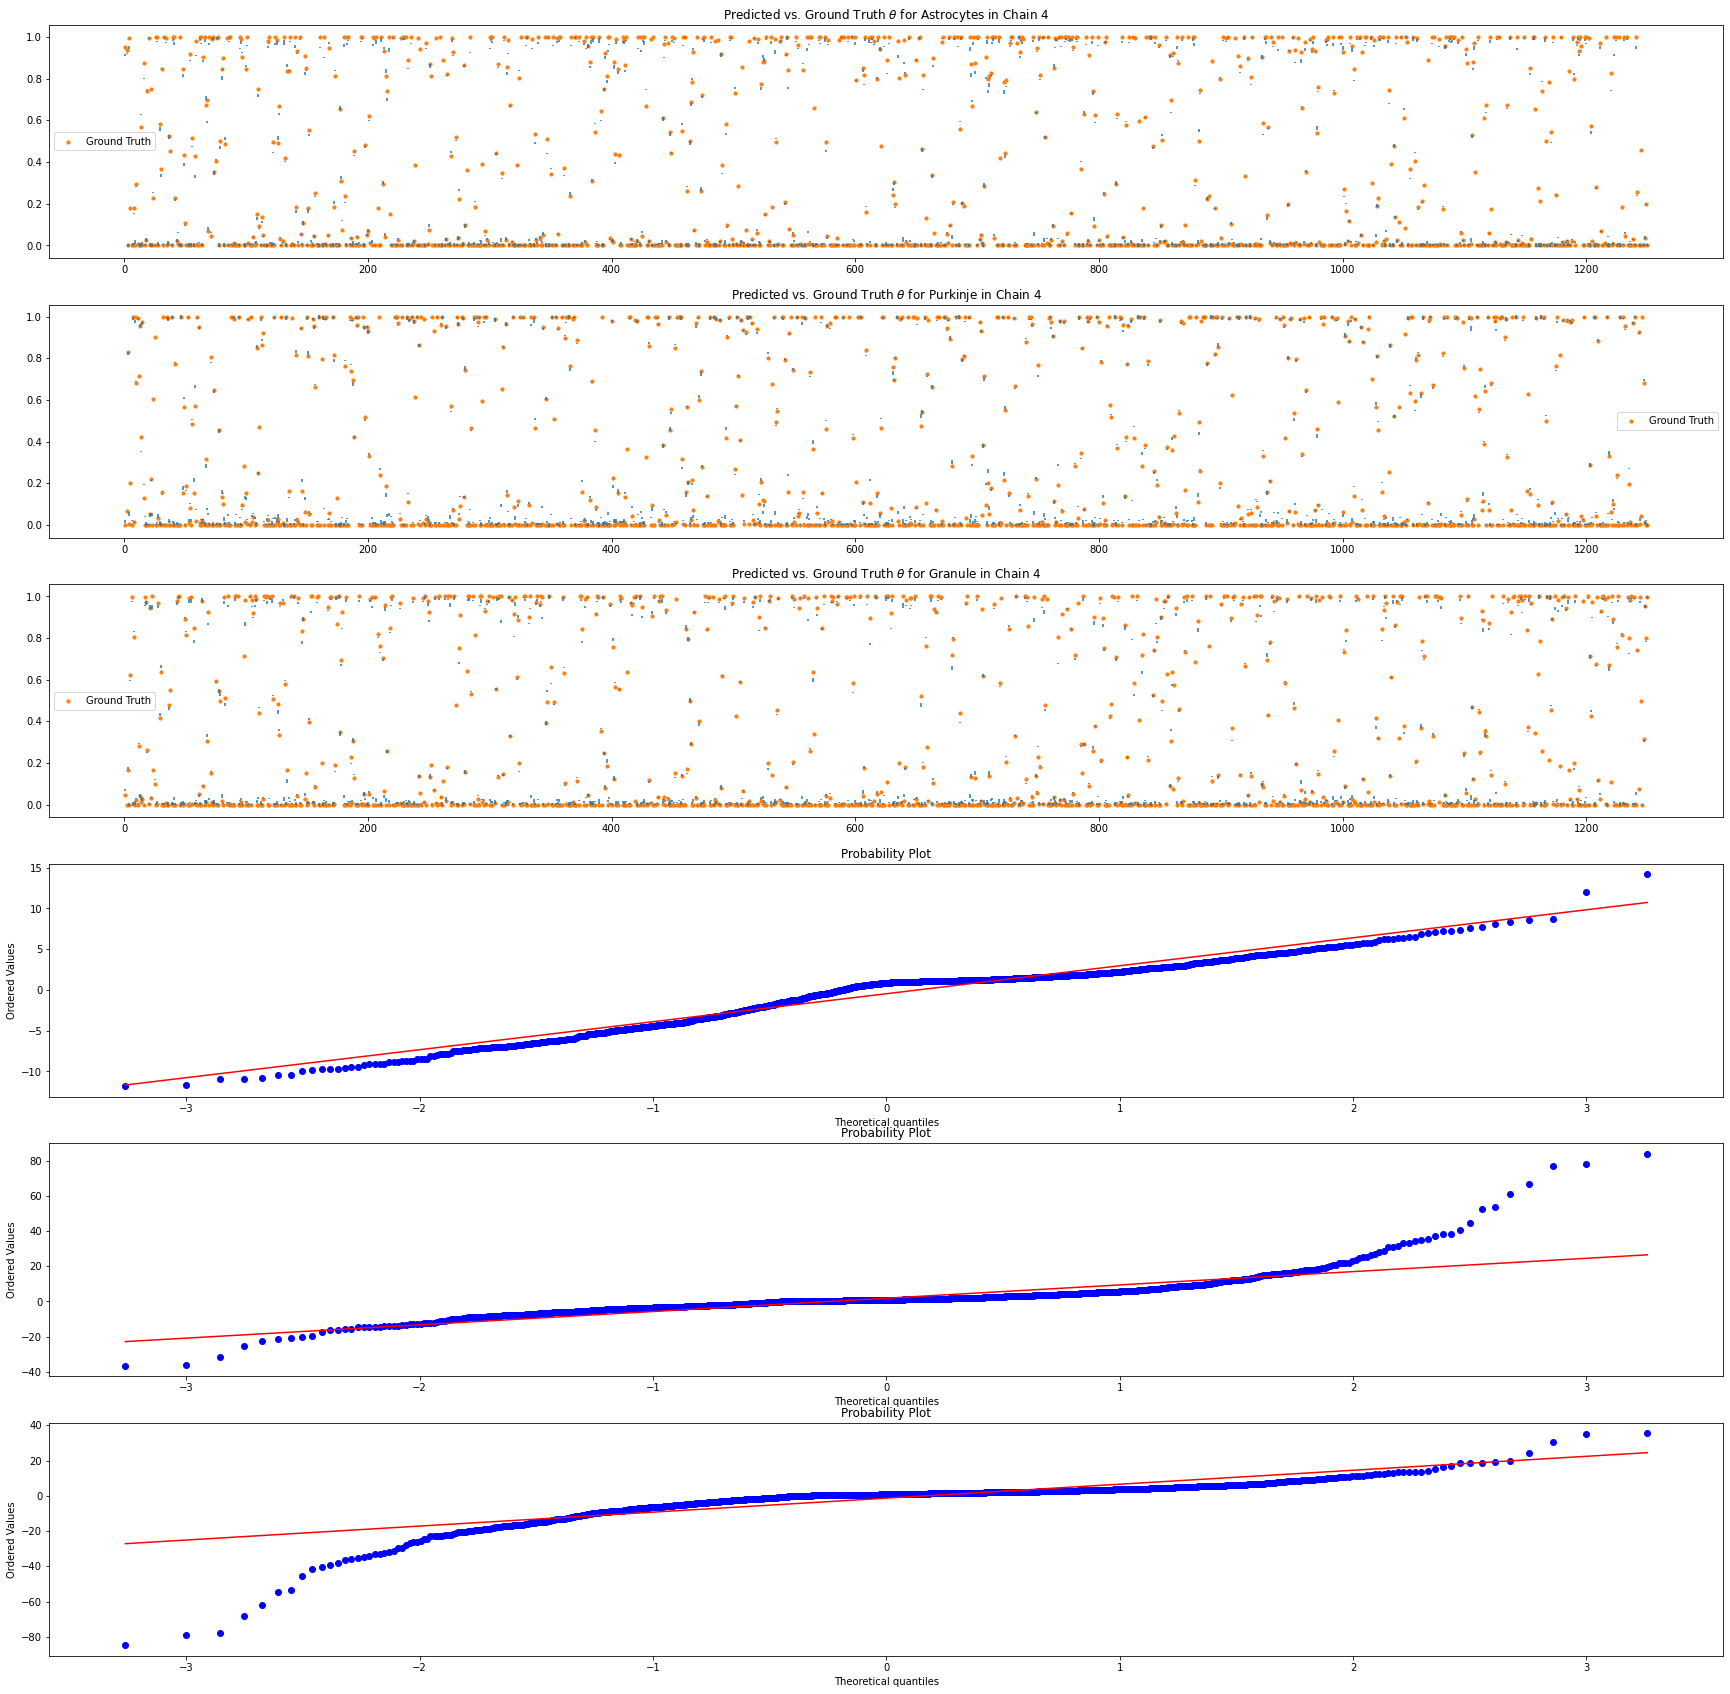

In [16]:
def plot_figs(chain,t,ps_theta,types,option="differences",P=500,samples=250):
    #plt.rcParams["figure.figsize"] = (30,12)

    X = range(1,P+1)
    
    if option == "differences":
        fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(30,30))
        for i, (ax, cell_type) in enumerate(zip([ax1, ax2, ax3],types)):
            ax.set_title(r"Predicted vs. Ground Truth $\theta$ for %s in Chain %s" % (cell_type,chain))
            truth = t[[cell_type]].squeeze().to_numpy()
            pred = ps_theta.loc[:, samples * (chain-1) : samples*chain - 1].mean(axis=1)[P*i:P*(i+1)].to_numpy()
            ps_t = ps_theta.loc[:, samples * (chain-1) : samples*chain - 1]
            differences = []
            for i, (a, b) in enumerate(zip(truth,pred)):
                ax.plot([i+1,i+1],[a,b],'k-',c="tab:gray")
            ax.scatter(X, truth, s=10, label="Ground Truth")
            ax.scatter(X, pred, s=30, label="Predicted")
            ax.legend()

        plt.savefig(os.path.join(figs_path,"2l-chain_%s.png" % chain),dpi=80,quality=80)
        plt.show()
    if option == "qqplot":
        fig, (ax1, ax2, ax3, hg1, hg2, hg3) = plt.subplots(6,figsize=(30,30))
        
        for i, (ax, hg, cell_type) in enumerate(zip([ax1, ax2, ax3], [hg1, hg2, hg3],types)):
            ax.set_title(r"Predicted vs. Ground Truth $\theta$ for %s in Chain %s" % (cell_type,chain))
            truth = t[[cell_type]].squeeze().to_numpy()
            pred = ps_theta.loc[:, samples * (chain-1) : samples*chain - 1].mean(axis=1)[P*i:P*(i+1)].to_numpy()
            ps_t = ps_theta.loc[:, samples * (chain-1) : samples*chain - 1]
            differences = []
            for i, (a, b) in enumerate(zip(truth,pred)):
                differences.append((b-a)/(ps_t[i:i+1].std(axis=1)[0]))
            ax.scatter(X, truth, s=10, label="Ground Truth",c="tab:orange")
            ax.errorbar(X,pred,yerr=[ps_t[i:i+1].std(axis=1)[0] for i in X],fmt="none")
            ax.legend()
            stats.probplot(differences, dist="norm",plot=hg)

        plt.savefig(os.path.join(figs_path,"2l-qqplot_%s.png" % chain),dpi=80,quality=80)
        plt.show()

option = "qqplot"
P=1250
        
ps_theta = ps.transpose()[ps.transpose().index.str.match(r"(theta)")]
plot_figs(1,t,ps_theta,["Purkinje", "Astrocytes", "Granule"],P=P,option=option)
plot_figs(2,t,ps_theta,["Granule", "Purkinje", "Astrocytes"],P=P,option=option)
plot_figs(3,t,ps_theta,["Purkinje", "Astrocytes", "Granule"],P=P,option=option)
plot_figs(4,t,ps_theta,["Astrocytes", "Purkinje", "Granule"],P=P,option=option)